In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from scipy.special import jv
from scipy.optimize import curve_fit

In [2]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon_0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

$^1S_0 |1/2, +-1/2\rangle $ light shift:  -9.475 Hz/W/cm-2

$^3P_1 |3/2, +-3/2\rangle $ light shift:  -3.7 Hz/W/cm-2 

$^3P_1 |3/2, +-1/2\rangle $ light shift:  -7.5 Hz/W/cm-2

$^3P_1 |1/2, +-1/2\rangle $ light shift:  -5.6 Hz/W/cm-2

In [11]:
def light_shift(F, mF, Psingle):
    
    ground = -9.475*1e-4
    f32mf32 = -3.7*1e-4
    f32mf12 = -7.5*1e-4
    f12mf12 = -7.5*1e-4
    
    if F==1/2:
        excited = f12mf12
    elif F==3/2 and abs(mF)==3/2:
        excited = f32mf32
    elif F==3/2 and abs(mF)==1/2:
        excited = f32mf12
        

    w0 = 0.46e-6 #tweezer waist    
    I0 = 2*Psingle/np.pi/w0**2 #max intensity
    
    return (excited-ground)*I0*h

In [12]:
def Zeeman_shift(F, mF, B):

    L = 1
    S = 1
    J = 1
    I = 1/2

    gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
    gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ

    return mB*gF*B*mF

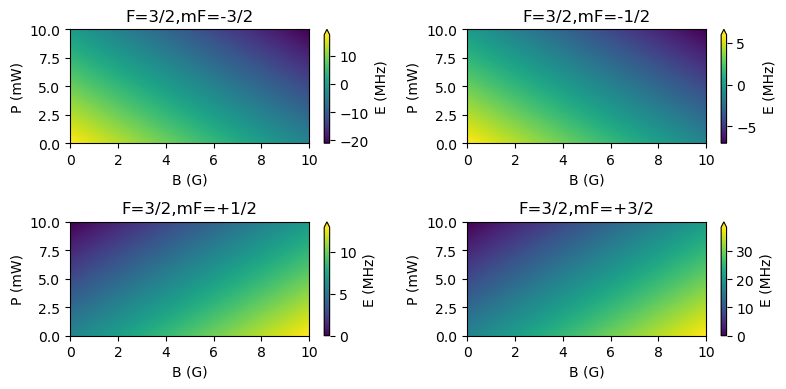

In [13]:
F=3/2
mF_arr=[-3/2, -1/2, 1/2, 3/2]

Psingle_arr = np.linspace(0, 1e-2, 100)
Bfield_arr = np.linspace(0, 10e-4, 100)

nrows, ncols = 100, 100

Elevels_all = []
for mF in mF_arr: 
    Elevels = []
    for p in Psingle_arr:
        for b in Bfield_arr:
            Elevels.append( (Zeeman_shift(F, mF, b) + light_shift(F, mF, p))/h*1e-6 )
    grid = np.reshape(Elevels, (nrows, ncols))
    Elevels_all.append(grid)

x0min = np.min(Bfield_arr*1e4)
x0max = np.max(Bfield_arr*1e4)
y0min = np.min(Psingle_arr*1e3)
y0max = np.max(Psingle_arr*1e3)
extent=[x0min, x0max, y0min, y0max]

fig, _ax = plt.subplots(2,2, figsize=[8,4], dpi=100)
ax = _ax.flatten()
mF_name = ['-3/2', '-1/2', '+1/2', '+3/2']
for i, mF in enumerate(mF_arr):
    im = ax[i].imshow(Elevels_all[i], aspect='auto', extent=extent)
    ax[i].set_xlabel('B (G)')
    ax[i].set_ylabel('P (mW)')
    ax[i].set_title('F=3/2,'+'mF='+mF_name[i])
    fig.colorbar(im, extend='max', label='E (MHz)', ax=ax[i])
plt.tight_layout()

mF= -1.5 : -37.87 MHz
mF= -0.5 : -12.51 MHz
mF= 0.5 : 21.08 MHz
mF= 1.5 : 62.91 MHz


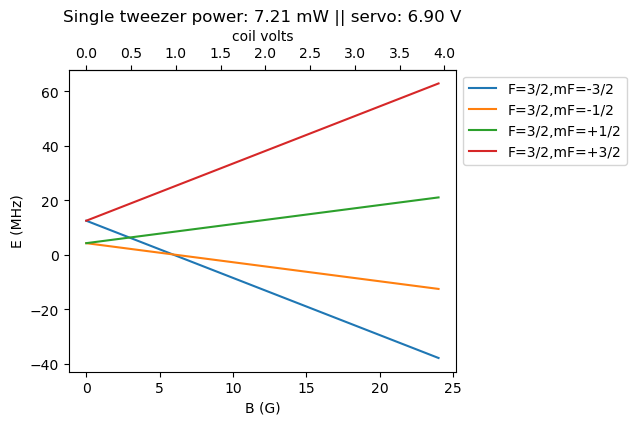

In [16]:
F=3/2
mF_arr=[-3/2, -1/2, 1/2, 3/2]

Pmeasured = 780e-3 #in the telescope at 3.07 V
volt = 6.9
N = 100 #number of traps
CLIPPeff = 0.85 #clipping on dichroic
OBJeff = 0.92 #objective transmission eff

Psingle = Pmeasured*CLIPPeff*OBJeff/N * volt/5.84 #power for single tweezer
Bfield_arr = np.linspace(0, 24e-4, 100)

Elevels_all = []
for mF in mF_arr: 
    Elevels = []
    for b in Bfield_arr:
        Elevels.append( (Zeeman_shift(F, mF, b) + light_shift(F, mF, Psingle))/h*1e-6 )
    Elevels_all.append(Elevels)

fig, ax = plt.subplots(1,1, figsize=[5,4], dpi=100)
mF_name = ['-3/2', '-1/2', '+1/2', '+3/2']
for i, mF in enumerate(mF_arr):
    ax.plot(Bfield_arr*1e4, Elevels_all[i], label = 'F=3/2,'+'mF='+mF_name[i])
    print('mF= %s : %.2f MHz' %(mF,Elevels_all[i][-1]))
ax.set_xlabel('B (G)')
ax.set_ylabel('E (MHz)')
ax.set_title('Single tweezer power: %.2f mW || servo: %.2f V' %(Psingle*1e3, volt))

def B2V(B):
    return B/6.1

def V2B(V):
    return 6.1*V

ax2 = ax.secondary_xaxis('top', functions=(B2V, V2B))
ax2.set_xlabel('coil volts')

plt.legend(bbox_to_anchor=(1,1))

mF= -1.5 : 10.26 MHz
mF= -0.5 : 3.51 MHz
mF= 0.5 : 3.51 MHz
mF= 1.5 : 10.26 MHz


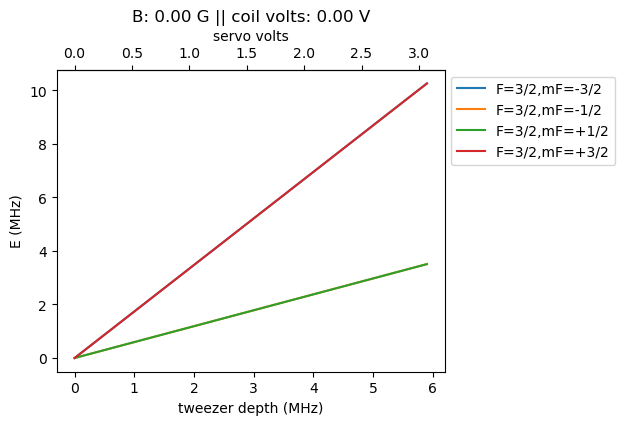

In [15]:
F=3/2
mF_arr=[-3/2, -1/2, 1/2, 3/2]

Pmeasured = 370e-3 #in the telescope at 3.07 V
volt = np.linspace(0, 3.07)
N = 49 #number of traps
CLIPPeff = 0.85 #clipping on dichroic
OBJeff = 0.92 #objective transmission eff
w0=0.46e-6
alpha = 37.9e-4

Psingle_arr = Pmeasured*(volt/3.07)*CLIPPeff*OBJeff/N #power for single tweezer
I_arr = np.multiply(Psingle_arr, 2/np.pi/w0**2)
depth = np.multiply(I_arr, alpha/4)
Bfield = 0

Elevels_all = []
for mF in mF_arr: 
    Elevels = []
    for p in Psingle_arr:
        Elevels.append( (Zeeman_shift(F, mF, Bfield) + light_shift(F, mF, p))/h*1e-6 )
    Elevels_all.append(Elevels)

fig, ax = plt.subplots(1,1, figsize=[5,4], dpi=100)
mF_name = ['-3/2', '-1/2', '+1/2', '+3/2']
for i, mF in enumerate(mF_arr):
    ax.plot(Psingle_arr*1e3, Elevels_all[i], label = 'F=3/2,'+'mF='+mF_name[i])
    print('mF= %s : %.2f MHz' %(mF,Elevels_all[i][-1]))
ax.set_xlabel('tweezer depth (MHz)')
ax.set_ylabel('E (MHz)')
ax.set_title('B: %.2f G || coil volts: %.2f V' %(Bfield*1e4, Bfield*1e4/6.1))
#ax.set_ylim(0, 15)

def P2V(P):
    return P/Pmeasured/1e3*3.07/CLIPPeff/OBJeff*N

def V2P(V):
    return V*Pmeasured*1e3/3.07*CLIPPeff*OBJeff/N

ax2 = ax.secondary_xaxis('top', functions=(P2V, V2P))
ax2.set_xlabel('servo volts')

plt.legend(bbox_to_anchor=(1,1))